# Clusteranalyse

Schritte zur Vorbereitung, später evtl. schon im Preprossessing erledigt:

Format
- Datumsspalte in Jahr, Monat, Tag trennen

Daten entfernen
- **Zeilen** aus 2014 und 2025 entfernen, weil zu wenige Datenpunkte
- **Spalten** mit zu vielen fehlenden Werten entfernen (cut-off: 53% missing values)
- Alle Einträge für **Tehran** entfernen, weil die Stadt durch ihre extrem hohen Schadstoffwerte die Clusteranalyse verzerrt

Aktuell auch noch relevant, aber im großen Datensatz vielleicht nicht mehr
- Bestimmen, in welchen der 95 Städte für **alle Schadstoffe** Messwerte vorliegen --> 54 Städte

Clusteranalyse
- StandardScaler und KMeans importieren
- Liste der Schadstoffe definieren (pollutants)
- gruppierten ("City") und reduzierten ("dropna") mit Mittelwerten ("mean") df nach Städten und Schadstoffen für als Datengrundlage der Clusteranalyse erstellen (**df_cluster**). df-cluster hat 53 Zeilen (Städte) und 6 Spalten (Schadstoffe)
- Daten skalieren (**df_cluster_scaled**)
- mit Ellbow-Methode optimale Clusteranzahl bestimmen --> 5 Cluster (Silhouette wurde auch getestet, brachte keinen Mehrwert)
- mit Kmeans Clusterzuordnung durchführen (**df_cluster_numbers**)

In [1]:
# imports
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("/Users/mareikekeller/air_quality/data/cleaned_data.csv")
df.head()

,Date,Country,City,aqi,co,d,dew,humidity,mepaqi,no2,...,pol,precipitation,pressure,psi,so2,temperature,uvi,wd,wind-gust,wind-speed
0,2014-12-29,AT,Vienna,NaN,0.10,NaN,NaN,NaN,NaN,9.00,...,NaN,NaN,NaN,NaN,2.60,NaN,NaN,NaN,NaN,NaN
1,2014-12-29,AU,Brisbane,NaN,1.90,NaN,NaN,NaN,NaN,4.60,...,NaN,NaN,NaN,NaN,1.10,NaN,NaN,NaN,NaN,NaN
2,2014-12-29,BE,Brussels,NaN,0.10,NaN,NaN,NaN,NaN,23.40,...,NaN,NaN,NaN,NaN,1.60,NaN,NaN,NaN,NaN,NaN
3,2014-12-29,BO,Cochabamba,NaN,NaN,NaN,NaN,NaN,NaN,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-29,BR,São Paulo,NaN,5.50,NaN,NaN,NaN,NaN,17.90,...,NaN,NaN,NaN,NaN,1.10,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data preparation: Manipulating the 'Date' column

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Split 'Date' column into 'year', 'month' and 'day'
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# Remove 'Date' column
if 'Date' in df.columns:
    df.drop(columns=['Date'], inplace=True)

In [5]:
# Daten für 2014 & 2025 entfernen, weil zu wenige Datenpunkte

df = df[(df["year"] > 2014) & (df["year"] < 2025)]

In [6]:
# Tehran komplett entfernen, weil die Schadstoffwerte zu sehr von allen übrigen Städten abweichen
df = df[df["City"] != "Tehran"]

In [7]:
print("Tehran noch im DataFrame?", "Tehran" in df["City"].values)

Tehran noch im DataFrame? False


In [8]:
df['City'].nunique()

94

In [9]:
# Display the first 5 rows of the dataframe
df.head()

,Country,City,aqi,co,d,dew,humidity,mepaqi,no2,o3,...,psi,so2,temperature,uvi,wd,wind-gust,wind-speed,year,month,day
139,AT,Vienna,NaN,0.10,NaN,NaN,NaN,NaN,7.80,NaN,...,NaN,2.60,NaN,NaN,NaN,NaN,NaN,2015,1,1
140,AU,Brisbane,NaN,1.90,NaN,NaN,NaN,NaN,1.90,4.90,...,NaN,1.10,NaN,NaN,NaN,NaN,NaN,2015,1,1
141,BE,Brussels,NaN,0.10,NaN,NaN,NaN,NaN,12.40,16.30,...,NaN,1.60,NaN,NaN,NaN,NaN,NaN,2015,1,1
142,BO,Cochabamba,NaN,NaN,NaN,NaN,NaN,NaN,4.30,10.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,1
143,BR,São Paulo,NaN,4.60,NaN,NaN,NaN,NaN,7.40,19.50,...,NaN,1.10,NaN,NaN,NaN,NaN,NaN,2015,1,1


In [10]:
df.shape

(218703, 26)

In [11]:
# Spalten mit zu vielen fehlenden Werten entfernen

# Berechnen, wie viele Prozent der Werte pro Spalte fehlen
missing_percent = df.isna().mean() * 100  

# Spalten auswählen, die weniger als 50% fehlende Werte haben
df_cleaned = df.loc[:, missing_percent <= 53]

# Ergebnis ausgeben
print(f"Anzahl der entfernten Spalten: {df.shape[1] - df_cleaned.shape[1]}")
print("Übrige Spalten:", df_cleaned.columns)


Anzahl der entfernten Spalten: 9
Übrige Spalten: Index(['Country', 'City', 'co', 'dew', 'humidity', 'no2', 'o3', 'pm10', 'pm25',
       'pressure', 'so2', 'temperature', 'wind-gust', 'wind-speed', 'year',
       'month', 'day'],
      dtype='object')


In [12]:
df_cleaned["City"].nunique()

94

In [12]:
# # Mit Heatmap herausfinden, welche Städte für welche Schadstoffe fehlende Werte haben

# # Liste der Schadstoff-Features für das Clustering
# pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# # DataFrame mit den Schadstoffen pro Stadt erstellen
# df_missing = df_cleaned.groupby("City")[pollutants].mean()

# # Boolean-Maske für fehlende Werte erstellen (True = fehlend, False = vorhanden)
# missing_data = df_missing.isna()

# # Größe der Grafik anpassen
# plt.figure(figsize=(8, 20))

# # Heatmap zeichnen (dunklere Farben = mehr fehlende Werte)
# sns.heatmap(missing_data, cmap="coolwarm", cbar=False, linewidths=0.5)

# # Achsentitel setzen
# plt.xlabel("Schadstoffe")
# plt.ylabel("Städte")
# plt.title("Heatmap der fehlenden Werte pro Stadt und Schadstoff")


In [ ]:
# missing_per_city = df_missing.isna().sum(axis=1)
# missing_per_city_sorted = missing_per_city.sort_values(ascending=False)
# print(missing_per_city_sorted.to_string())


## Code für Clusteranalyse (K-Means) zur Schadstoffbelastung

In [13]:
# Clusteranalyse zur Schadstoffbelastung

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Liste der Schadstoff-Features für das Clustering
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# Durchschnittliche Schadstoffwerte pro Stadt berechnen
df_cluster = df_cleaned.groupby("City")[pollutants].mean().dropna()



In [14]:
df_cluster.head()

,co,no2,o3,so2,pm10,pm25
City,,,,,,
Abu Dhabi,0.10,12.10,27.64,4.96,80.03,98.72
Amsterdam,2.86,10.22,19.80,0.40,15.90,39.81
Ankara,9.02,20.80,13.28,4.07,37.77,59.94
Athens,0.10,11.67,29.59,3.64,24.26,52.64
Belgrade,4.72,11.50,17.01,6.03,24.60,62.22


In [15]:
df_cluster.shape

(53, 6)

In [16]:
# Daten skalieren (K-Means ist empfindlich gegenüber unterschiedlichen Skalen)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Ergebnis als DataFrame zurückgeben
df_cluster_scaled = pd.DataFrame(df_scaled, index=df_cluster.index, columns=pollutants)

# Überprüfen, ob die Daten korrekt vorbereitet sind
df_cluster_scaled.head()

,co,no2,o3,so2,pm10,pm25
City,,,,,,
Abu Dhabi,-1.16,0.36,1.41,0.46,2.34,1.41
Amsterdam,-0.39,-0.04,0.34,-0.96,-0.69,-0.73
Ankara,1.33,2.21,-0.55,0.18,0.34,-0.00
Athens,-1.16,0.27,1.68,0.05,-0.30,-0.27
Belgrade,0.13,0.23,-0.04,0.80,-0.28,0.08


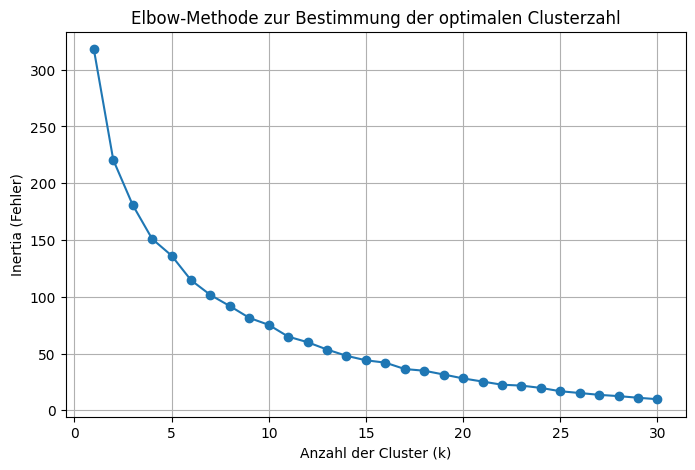

In [17]:
# Teste verschiedene Clusterzahlen (k = 1 bis 10)
inertia = []
k_values = range(1, 31)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)  # Speichert den Fehler (Inertia)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Fehler)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.grid(True);

In [23]:
# K-Means-Clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df_cluster_scaled["Cluster"] = kmeans.fit_predict(df_cluster_scaled)

# Neue Cluster-Zuordnung der Städte anzeigen
df_cluster_numbers = df_cluster_scaled[["Cluster"]].sort_values(by="Cluster")
df_cluster_numbers

,Cluster
City,
Hong Kong,0
Ankara,0
Belgrade,0
Quito,0
São Paulo,0
Moscow,0
Manila,0
Macau,0
Taipei,0


In [29]:
# Delhi wird bei 5 und 6 Clustern von KMeans als eigenes Cluster isoliert.
# Test, ob DBSCAN eine andere Clusterbildung erzielt

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3.5, min_samples=4)  # Parameter ggf. anpassen
df_cluster["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)

In [30]:
df_cluster["Cluster_DBSCAN"].value_counts()


Cluster_DBSCAN
 0    52
-1     1
Name: count, dtype: int64

In [31]:
df_cluster[df_cluster.index == "Delhi"]

,co,no2,o3,so2,pm10,pm25,Cluster_DBSCAN
City,,,,,,,
Delhi,9.33,16.32,9.24,5.46,130.19,163.57,-1


Entscheidung: 5 Cluster sind gut - aber Teheran it so dreckig, dass es allein sein eigens Cluster bildet. Also nehmen wir es erst mal raus, damit es die anderen Cluster nicht verzerrt. Dadurch nehmen wir für die Clusteranalyse aber nur noch 4 Cluster.

In [ ]:
# Cluster-Labels zu df_cluster hinzufügen
df_clusters_no_tehran_sorted["Cluster"] = kmeans.labels_

# Merge mit ursprünglichem DataFrame
df = df.merge(df_clusters_no_tehran_sorted[["Cluster"]], left_on="City", right_index=True, how="left")

# Überprüfen, ob die Cluster-Zuordnung funktioniert hat
df.head(20)


## Zusammenführung Geodaten und Clusternummern

In [39]:
import pandas as pd
df_check = pd.read_csv("df_geodata.csv")
df_check.head() 

FileNotFoundError: [Errno 2] No such file or directory: 'df_geodata.csv'